## Fake Job Classifier

The dataset used is the Employment Scam Aegean Dataset (EMSCAD) dataset which is provided publicly by the University of the Aegean Laboratory of Information & Communication Systems Security. This dataset contains 17,880 real-life job postings in which 17,014 are real and 866 are fake. This dataset is further processed and uploaded on the Kaggle and is available publicly. 

In [1]:
# pip install -U spacy

In [2]:
# pip install pycountry

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
#Importing Libraries
import re
import string
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, confusion_matrix
from wordcloud import WordCloud
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


In [5]:
#Reading dataset
df = pd.read_csv('C:/Users/meena/Documents/Data Mining/Project 1/Fake Job Posting/fake_job_postings.csv')
df2 = df.copy()
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


### Exploratory Data Analysis

In [6]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [7]:
#Fill NaN values with blank space
df.fillna(' ', inplace=True)

,fraudulent,title
0,0,17014
1,1,866


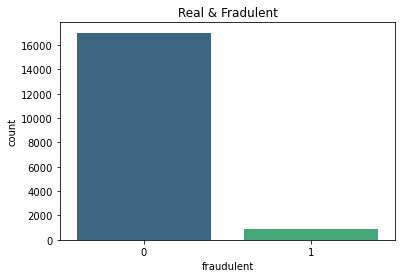

In [8]:
sns.countplot(df.fraudulent, palette= 'viridis').set_title('Real & Fradulent')
df.groupby('fraudulent').count()['title'].reset_index().sort_values(by='title',ascending=False)

In [9]:
# plt.figure(figsize = (10,10))
# corr = df.corr()
# sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) ,  square = True)

Text(0.5, 0, 'Countries')

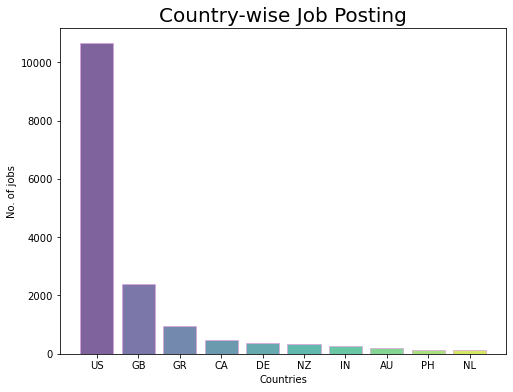

In [10]:
#Visualize job postings by countries
def split(location):
    l = location.split(',')
    return l[0]

df['country'] = df.location.apply(split)

country = dict(df.country.value_counts()[:11])
del country[' ']
plt.figure(figsize=(8,6))
plt.title('Country-wise Job Posting', size=20)
plt.bar(country.keys(), country.values(), color=sns.color_palette("viridis", len(country.keys())) , edgecolor= 'plum', alpha= 0.7)
plt.ylabel('No. of jobs', size=10)
plt.xlabel('Countries', size=10)


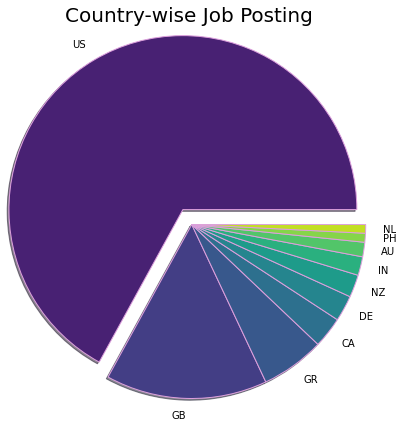

In [11]:
plt.title('Country-wise Job Posting \n \n \n \n', size=20)
plt.pie(country.values(), labels= country.keys(), radius= 2, colors=sns.color_palette("viridis", len(country.keys())),
        wedgeprops={"linewidth": 1, "edgecolor": "plum"}, shadow= True, explode= [0.2,0,0,0,0,0,0,0,0,0])
plt.show()

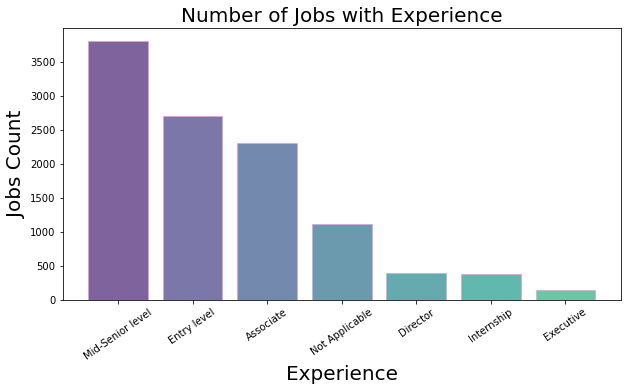

In [12]:
#Visualize the required experiences in the jobs
experience = dict(df.required_experience.value_counts())
del experience[' ']
plt.figure(figsize=(10,5))
plt.bar(experience.keys(), experience.values(), color= sns.color_palette("viridis", len(country.keys())), edgecolor= 'plum', alpha= 0.7)
plt.title('Number of Jobs with Experience', size=20)
plt.xlabel('Experience', size=20)
plt.ylabel('Jobs Count', size=20)
plt.xticks(rotation=35)
plt.show()

In [13]:
#Most frequent jobs
print(df.title.value_counts()[:10])

English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        75
Web Developer                                          66
Project Manager                                        62
Name: title, dtype: int64


In [14]:
#Most frequent requirements or qualifications
print(df.requirements.value_counts()[:10])

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    2695
University degree required. TEFL / TESOL / CELTA or teaching experience preferred but not necessaryCanada/US passport holders only                                                             

In [15]:
#Filtering out the fraudulent jobs
fraudulent_data = df[df['fraudulent']==1]

#Distribution of fraudulent jobs 
df3 = dict(fraudulent_data.telecommuting.value_counts())
df4 = dict(fraudulent_data.has_company_logo.value_counts())
df5 = dict(fraudulent_data.has_questions.value_counts())
df6 = dict(fraudulent_data.employment_type.value_counts())
d7 = dict(fraudulent_data.industry.value_counts())
# del data6[' ']
# del data7[' ']


Text(0, 0.5, 'Count')

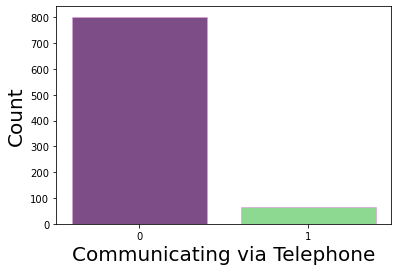

In [16]:
plt.bar(df3.keys(), df3.values(), edgecolor= 'plum', alpha= 0.7,color=['#440154','#5ec962'], tick_label=[0,1])
plt.xlabel('Communicating via Telephone', size=20)
plt.ylabel('Count', size=20)

Text(0, 0.5, 'Count')

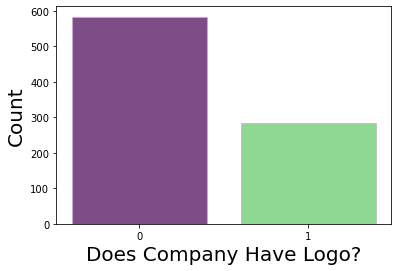

In [17]:
plt.bar(df4.keys(), df4.values(), color= ['#440154','#5ec962'], edgecolor= 'plum', alpha= 0.7, tick_label=[0,1])
plt.xlabel('Does Company Have Logo?', size=20)
plt.ylabel('Count', size=20)

Text(0, 0.5, 'Count')

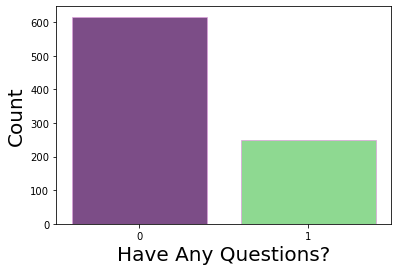

In [18]:
plt.bar(df5.keys(), df5.values(), color= ['#440154','#5ec962'], edgecolor= 'plum', alpha= 0.7, tick_label=[0,1])
plt.xlabel('Have Any Questions?', size=20)
plt.ylabel('Count', size=20)

Text(0, 0.5, 'Count')

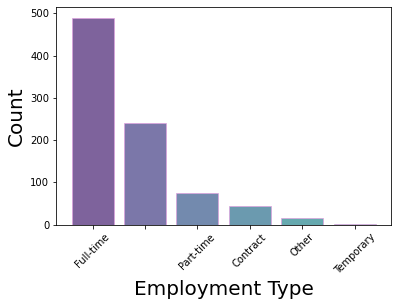

In [19]:
plt.xticks(rotation='45')
plt.bar(df6.keys(), df6.values(), color= sns.color_palette("viridis",len(country.keys())), edgecolor= 'plum', alpha= 0.7)
plt.xlabel('Employment Type', size=20)
plt.ylabel('Count', size=20)

As seen from the graph, full-time jobs are clearly more succeptible to fraud than part-time or contract based jobs.

Text(0, 0.5, 'Industry')

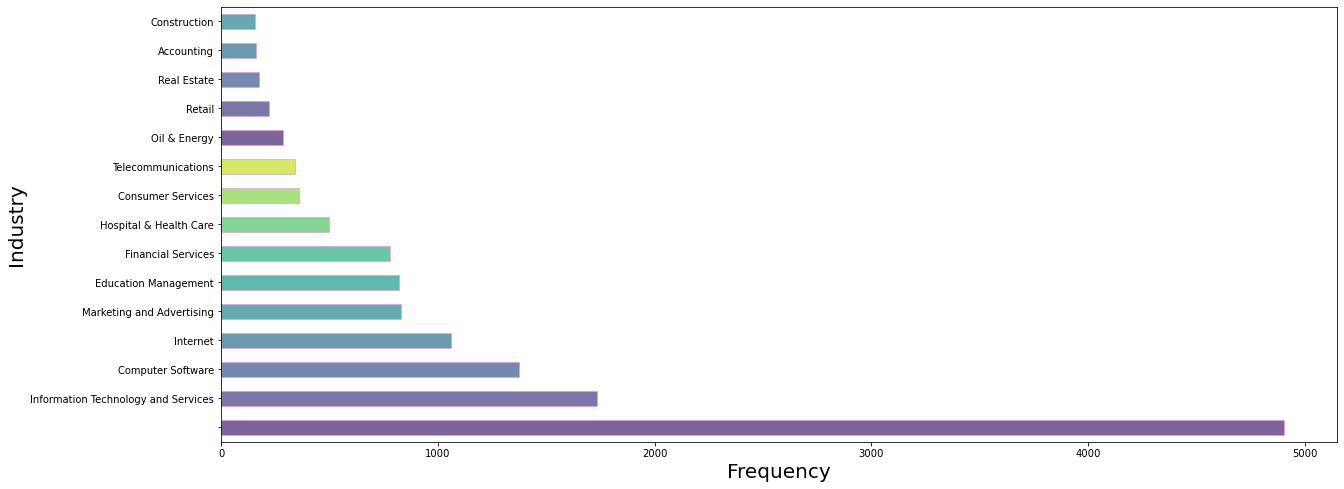

In [20]:
plt.figure(figsize=(20,8))
df['industry'].value_counts()[:15].plot(kind='barh',  color= sns.color_palette("viridis", len(country.keys())), edgecolor= 'plum', alpha= 0.7)
plt.xlabel('Frequency', size=20)
plt.ylabel('Industry', size=20)

Text(0, 0.5, 'Industry')

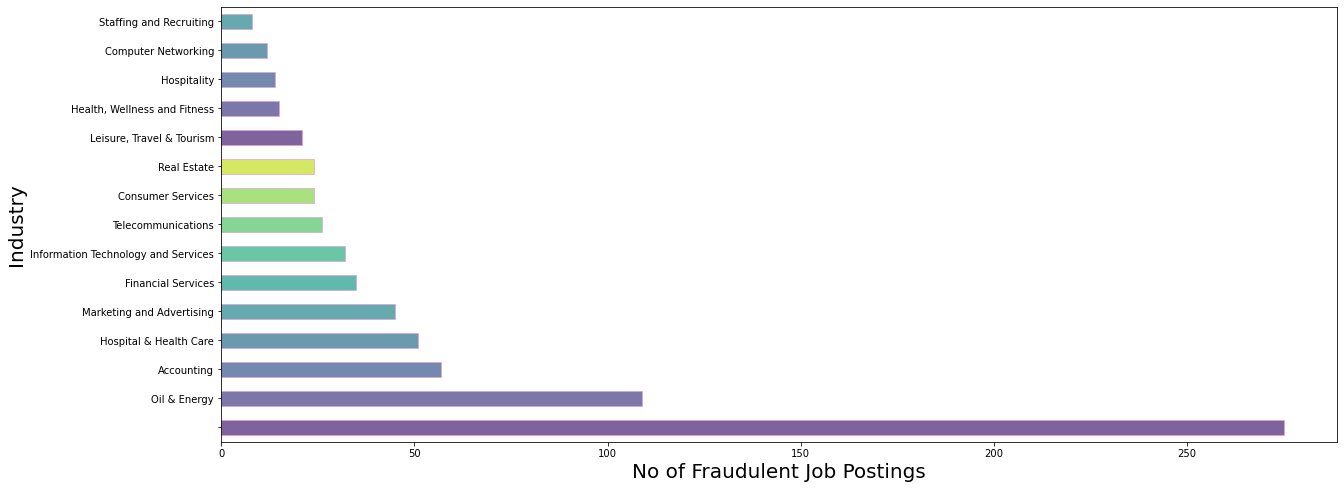

In [21]:
#Only including rows which are fake job postings.
df_industry = df[df['fraudulent']== 1]

plt.figure(figsize=(20,8))
df_industry['industry'].value_counts()[:15].plot(kind='barh',  color= sns.color_palette("viridis", len(country.keys())), edgecolor= 'plum', alpha= 0.7)
plt.xlabel('No of Fraudulent Job Postings', size=20)
plt.ylabel('Industry', size=20)

The high-paying, high-risk jobs in the industries like Oil & Energy, Accounting, Health Care, Advertising, Finance seem to attract scammers more.

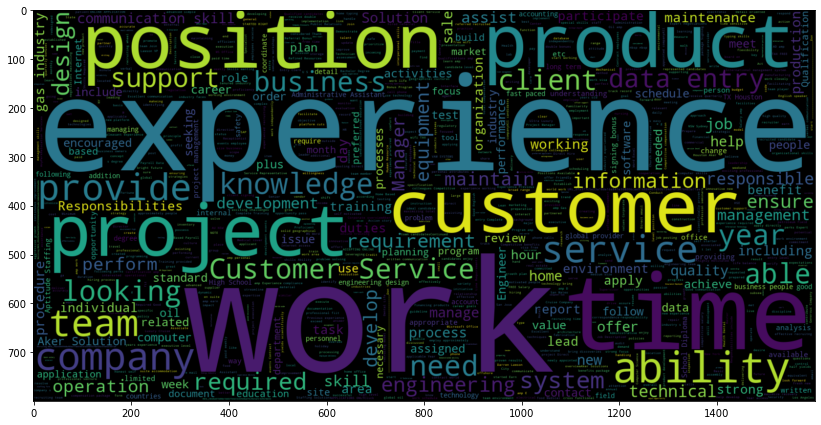

In [22]:
df['text']=df['title']+' '+df['location']+' '+df['company_profile']+' '+df['description']+' '+df['requirements']+' '+df['benefits']

fraudjobs_text = df[df.fraudulent==1].text
actualjobs_text = df[df.fraudulent==0].text

#Fraudulent jobs word cloud
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
plt.figure(figsize = (14,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(fraudjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

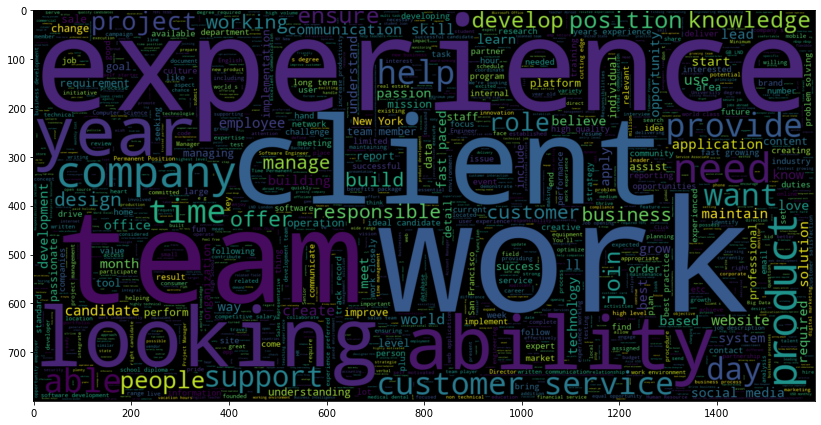

In [23]:
#Actual jobs wordcloud
plt.figure(figsize = (14,14))
wc = WordCloud(min_font_size = 3,  max_words = 3000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(str(" ".join(actualjobs_text)))
plt.imshow(wc,interpolation = 'bilinear')

From the two word clouds, we can see some differences. Fake jobs focus on words like data entry, equipment, oil & gas, design, technical, product etc. which are different from the words used to describe real job postings.

### Job title with max full time opportunities

In [24]:
#Subsetting dfframe which have 'Full-time' emplyment type and also are not fruad.
df_jobs = df[(df['employment_type'] == 'Full-time') & (df['fraudulent']== 0)]

#Checking the counts of each unique value
print(df_jobs['title'].value_counts()[0:10])

Customer Service Associate     145
Software Engineer               71
Account Manager                 64
Web Developer                   50
Account Executive               40
Customer Service Associate      40
Customer Service Team Lead      39
Product Manager                 39
Senior Software Engineer        37
Sales Representative            37
Name: title, dtype: int64


In [25]:
print("So the job title with max full time opportunities is : " ,list(dict(df_jobs['title'].value_counts()).keys())[0]
, " : ",df_jobs['title'].value_counts().max())


So the job title with max full time opportunities is :  Customer Service Associate   :  145


### Industry with Max Fake job postings

In [26]:
#Only including rows which are fake job postings.
df_industry = df[df['fraudulent']== 1]

#Checking each unique value counts of industry.
df_industry['industry'].value_counts()

                               275
Oil & Energy                   109
Accounting                      57
Hospital & Health Care          51
Marketing and Advertising       45
                              ... 
Civic & Social Organization      1
Public Safety                    1
Wholesale                        1
Consumer Goods                   1
Online Media                     1
Name: industry, Length: 63, dtype: int64

In [27]:
print("Industry with, maximum no. of fake job postings : ",list(dict(df_industry['industry'].value_counts()).keys())[1])

Industry with, maximum no. of fake job postings :  Oil & Energy


### Data Cleaning & Feature Engineering

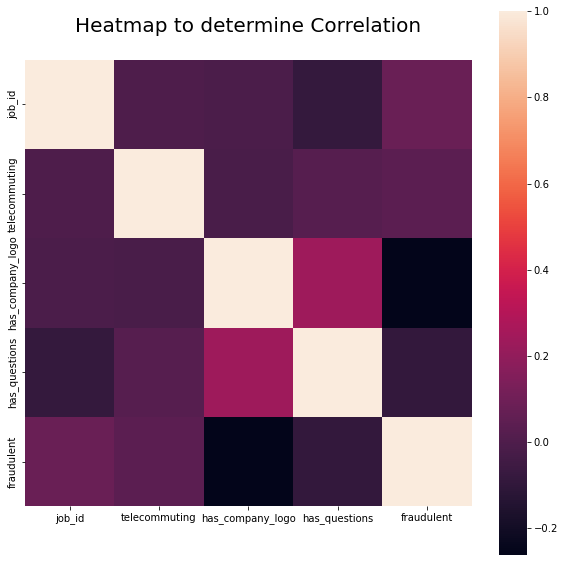

In [28]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) ,  square = True)
plt.title("Heatmap to determine Correlation\n",fontsize=20)
plt.show()

In [29]:
#Dropping columns not useful for analysis
df2.drop(['salary_range', 'job_id', 'department', 'benefits'], axis = 1, inplace = True)

In [30]:
df2 = df2.sort_values('title').reset_index(drop = True)

df2['employment_type'] = df2['employment_type'].bfill(axis=0)
df2['required_experience'] = df2['required_experience'].bfill(axis=0)
df2['required_education'] = df2['required_education'].bfill(axis = 0)
df2['industry'] = df2['industry'].bfill(axis=0)
df2['function'] = df2['function'].bfill(axis=0)

df2 = df2[df2['description'].notna()]
df2 = df2.dropna(axis = 0, how = 'any')
df2 = df2.drop_duplicates(keep = 'first')

df2['description'] = df2['description'] + ' ' + df2['requirements'] + ' ' + df2['company_profile']
df2.drop(['company_profile', 'requirements'], axis = 1, inplace = True)


df2['country_code'] = df2['location'].str.split(',', expand=True)[0]
df2['city'] = df2['location'].str.split(',', expand = True)[2]

df2.dropna(inplace = True)
df2.shape

(12232, 14)

In [31]:
import pycountry
list_alpha_2 = [i.alpha_2 for i in list(pycountry.countries)]
def country(df):
    if df['country_code'] in list_alpha_2:
        return pycountry.countries.get(alpha_2 = df['country_code']).name
df2['country_name'] = df2.apply(country, axis = 1)

In [32]:
df2.drop(['location', 'country_code'], axis = 1, inplace = True)

### Natural Language Processing

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
pd.set_option('display.max_columns', None)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem import WordNetLemmatizer
import string
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
import string 
import re
import spacy 
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

In [34]:
import spacy
nlp = spacy.load('en_core_web_sm')
import base64
import string
import re
from collections import Counter
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
punctuations = string.punctuation
def cleanup_text(docs, logging = False):
    texts = []
    for doc in docs:
        doc = nlp(doc, disable = ['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [35]:
STOPLIST = set(stopwords + list(ENGLISH_STOP_WORDS))
SYMBOLS = " ".join(string.punctuation).split(" ")
def tokenizetext(sample):
    text = sample.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    tokens = parser(text)
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    tokens = [tok for tok in tokens if tok not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    return tokens
vectorizer = CountVectorizer(tokenizer = tokenizetext, ngram_range = (1,3), min_df = 0.06)
vectorizer_features = vectorizer.fit_transform(df2['description'])

vectorized_df = pd.DataFrame(vectorizer_features.todense(), columns = vectorizer.get_feature_names())
df_vectorized = pd.concat([df2, vectorized_df], axis = 1)
df_vectorized.drop('description', axis = 1, inplace = True)
df_vectorized.dropna(inplace=True)

columns_to_1_hot = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']

for column in columns_to_1_hot:
    encoded = pd.get_dummies(df_vectorized[column])
    df_vectorized = pd.concat([df_vectorized, encoded], axis = 1)
    
columns_to_1_hot += ['title', 'city', 'country_name']
df_vectorized.drop(columns_to_1_hot, axis = 1, inplace = True)

In [36]:
target = df_vectorized.loc[:,'fraudulent'].values
features = df_vectorized.drop('fraudulent', axis = 1)
features=features.loc[:,:].values

#### Classification using ML libraries

In [37]:
Model_Name = []
Model_Score = []
F1_Score=[]
Accuracy_score=[]

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

### Overspamling using RandomOverSampler

In [38]:
import imblearn 
from imblearn.over_sampling import RandomOverSampler

# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy=0.5)

# fit and apply the transform
X_over, y_over = oversample.fit_resample(features,target)

Text(0.5, 1.0, 'Real & Fradulent')

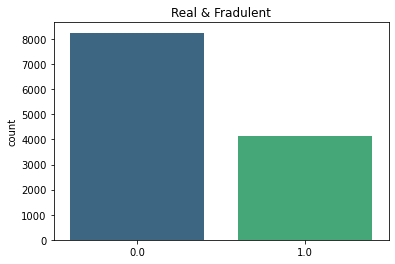

In [39]:
sns.countplot(y_over, palette= 'viridis').set_title('Real & Fradulent')


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.2, stratify = y_over, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9902, 194)
(2476, 194)
(9902,)
(2476,)


### Logistic Regression

In [41]:
log_reg = LogisticRegression()
c_values = [12]
penalty_options = ['l1', 'l2']

param_grid = dict(C = c_values, penalty = penalty_options)
grid_tfidf = GridSearchCV(log_reg, param_grid = param_grid, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose=1)
grid_tfidf.fit(X_train, y_train)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [12], 'penalty': ['l1', 'l2']}, scoring='roc_auc',
             verbose=1)

In [42]:
grid_tfidf.best_score_

0.9116940730267178

In [43]:
grid_tfidf.best_params_

{'C': 12, 'penalty': 'l2'}

In [44]:
log_reg_pred = grid_tfidf.predict(X_test)

In [45]:
roc_auc_score(y_test, log_reg_pred)

0.8051814327404878

In [46]:
print (classification_report(y_test, log_reg_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.90      0.88      1651
         1.0       0.78      0.71      0.74       825

    accuracy                           0.84      2476
   macro avg       0.82      0.81      0.81      2476
weighted avg       0.83      0.84      0.84      2476



In [47]:
Model_Name.append('Logistic_Regression')
Model_Score.append(round(roc_auc_score(y_test, log_reg_pred), 4))
F1_Score.append(round(f1_score(y_test, log_reg_pred),4))
Accuracy_score.append(round(accuracy_score(y_test, log_reg_pred),4))

In [48]:
confusion_matrix(y_test, log_reg_pred)

array([[1488,  163],
       [ 240,  585]], dtype=int64)

### KNN

In [49]:
knn = KNeighborsClassifier()
k_range = [19]
param_grid_knn = dict(n_neighbors = k_range)
print (param_grid_knn)

{'n_neighbors': [19]}


In [50]:
grid_knn = GridSearchCV(knn, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)
grid_knn.fit(X_train, y_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [19]}, scoring='roc_auc', verbose=1)

In [51]:
grid_knn.best_score_

0.9579501979592763

In [52]:
grid_knn.best_params_

{'n_neighbors': 19}

In [53]:
knn_pred = grid_knn.predict(X_test)
print (roc_auc_score(y_test, knn_pred))
print (classification_report(y_test, knn_pred))

0.9070249435603766
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90      1651
         1.0       0.73      1.00      0.84       825

    accuracy                           0.88      2476
   macro avg       0.86      0.91      0.87      2476
weighted avg       0.91      0.88      0.88      2476



In [54]:
Model_Name.append('KNN')
Model_Score.append(round(roc_auc_score(y_test, knn_pred), 4))
F1_Score.append(round(f1_score(y_test, knn_pred),4))
Accuracy_score.append(round(accuracy_score(y_test, knn_pred),4))

In [55]:
confusion_matrix(y_test, knn_pred)

array([[1350,  301],
       [   3,  822]], dtype=int64)

### Random Forest

In [56]:
rf = RandomForestClassifier()
n_estimators_range = [14]
param_grid_rf = dict(n_estimators = n_estimators_range)
grid_rf = GridSearchCV(rf, param_grid_rf, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 1)

In [57]:
grid_rf.fit(X_train, y_train)
print (grid_rf.best_score_)
print (grid_rf.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
0.9998485994590383
{'n_estimators': 14}


In [58]:
rf_pred = grid_rf.predict(X_test)
print (roc_auc_score(y_test, rf_pred))
print (classification_report(y_test, rf_pred))

0.9966686856450636
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      1651
         1.0       0.99      1.00      0.99       825

    accuracy                           1.00      2476
   macro avg       0.99      1.00      1.00      2476
weighted avg       1.00      1.00      1.00      2476



In [59]:
Model_Name.append('Random_Forest')
Model_Score.append(round(roc_auc_score(y_test, rf_pred), 4))
F1_Score.append(round(f1_score(y_test, rf_pred),4))
Accuracy_score.append(round(accuracy_score(y_test, rf_pred),4))

In [60]:
confusion_matrix(y_test, rf_pred)

array([[1640,   11],
       [   0,  825]], dtype=int64)

### AUC-ROC Curve for Random Forest

In [61]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = grid_rf.predict_proba(X_test)[:,1]
# lr_probs = mlp_pred[1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

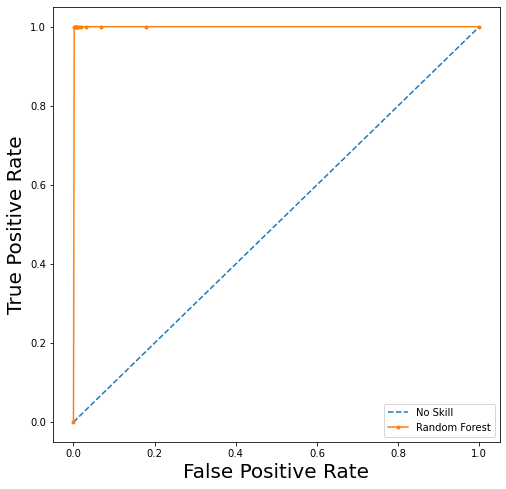

In [62]:
from sklearn.metrics import roc_curve
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.figure(figsize=(8,8))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
# show the legend
plt.legend()
# show the plot
plt.show()

### Multi-layer perceptron

In [63]:
mlp = MLPClassifier(solver = 'adam', activation = 'relu', hidden_layer_sizes = (100, 50, 30), max_iter = 1000)
mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(100, 50, 30), max_iter=1000)

In [64]:
mlp_pred = mlp.predict(X_test)
print (roc_auc_score(y_test, mlp_pred))
print (classification_report(y_test, mlp_pred))

0.9563797881908118
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1651
         1.0       0.90      0.97      0.93       825

    accuracy                           0.95      2476
   macro avg       0.94      0.96      0.95      2476
weighted avg       0.96      0.95      0.95      2476



In [65]:
Model_Name.append('MLP-NN')
Model_Score.append(round(roc_auc_score(y_test, mlp_pred), 4))
F1_Score.append(round(f1_score(y_test, mlp_pred),4))
Accuracy_score.append(round(accuracy_score(y_test, mlp_pred),4))

In [66]:
Model_Name

['Logistic_Regression', 'KNN', 'Random_Forest', 'MLP-NN']

In [67]:
confusion_matrix(y_test, mlp_pred)

array([[1563,   88],
       [  28,  797]], dtype=int64)

In [68]:
Model_Score

[0.8052, 0.907, 0.9967, 0.9564]

In [69]:
F1_Score

[0.7438, 0.8439, 0.9934, 0.9322]

In [70]:
Accuracy_score

[0.8372, 0.8772, 0.9956, 0.9532]

### Comparison of all models

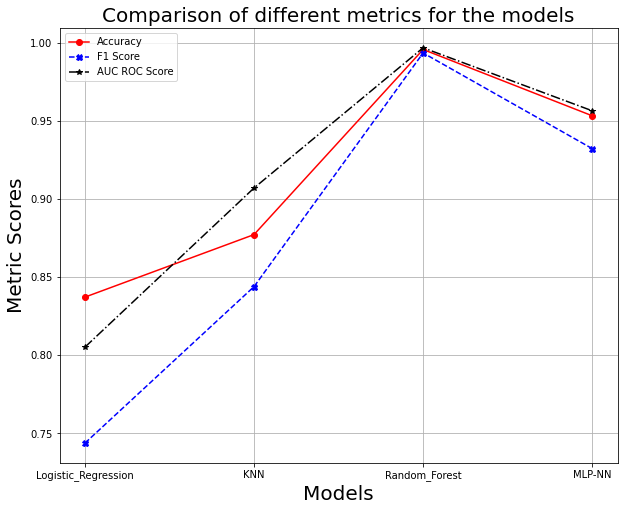

In [71]:
plt.figure(figsize = (10, 8))
plt.plot(Model_Name,Accuracy_score, marker = 'o', linestyle="-", color = 'red', label = "Accuracy")
plt.plot(Model_Name,F1_Score, marker = 'X', linestyle="--", color = 'Blue', label = "F1 Score")
plt.plot(Model_Name,Model_Score, marker = '*', linestyle="-.", color = 'Black', label = "AUC ROC Score")

plt.title('Comparison of different metrics for the models',size=20)
plt.xlabel('Models',size=20)
plt.ylabel('Metric Scores',size=20)
# plt.ylim(0.6, 1.0)
plt.grid()
plt.legend()
# plt.savefig('Model_compare.jpeg')
plt.show()

In [72]:
Error message

SyntaxError: invalid syntax (Temp/ipykernel_9252/2204801076.py, line 1)

### SVM - Takes extremely long ot train

In [ ]:
svc = SVC()
kernel = ['linear', 'rbf']
param_grid_knn = dict(kernel = kernel)
print (param_grid_knn)

In [ ]:
grid_svc = GridSearchCV(svc, param_grid_knn, cv = 10, scoring = 'roc_auc', n_jobs = -1, verbose = 2)
grid_svc.fit(X_train, y_train)

In [ ]:
grid_svc.best_score_

In [ ]:
grid_svc.best_params_

In [ ]:
svc_pred = grid_svc.predict(X_test)
print (roc_auc_score(y_test, svc_pred))
print (classification_report(y_test, svc_pred))

In [ ]:
Model_Name.append('SVC')
Model_Score.append(round(roc_auc_score(y_test, svc_pred), 4))
F1_Score.append(round(f1_score(y_test, svc_pred),4))
Accuracy_score.append(round(accuracy_score(y_test, svc_pred),4))